In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *
from wsc import *

(CVXPY) Mar 07 09:24:28 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [3]:
data_raw = pd.read_csv('../data/sales/sales.csv')
data_raw = data_raw[['Store', 'Date', 'Sales']]

C:\Users\16266\AppData\Local\Temp\ipykernel_12568\2178380782.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv('../data/sales/sales.csv')


In [4]:
data = data_raw.pivot(index='Store', columns='Date', values='Sales')

In [5]:
zero_proportion = (data == 0).sum() / data.shape[0]
threshold = 0.5
data = data.loc[:, zero_proportion < threshold].fillna(0)
M = np.transpose(data.values.copy())/1000
M[M==0] = np.mean(M)

In [6]:
# Matrix shape and rank
n1, n2 = M.shape
k = 5
r = 5
prop_obs = 0.1
random_state = 1
allow_inf = False
alpha = 0.1

In [7]:
max_test_queries = 1000
sampler = QuerySampling(n1,n2)

# Split observation mask and test mask
mask_obs, mask_test = sampler.sample_submask(sub_size=prop_obs, random_state=random_state)

# Sample test queries
n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), max_test_queries)
_, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)

In [8]:
max_calib_queries = 2000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

Observation size: 86970, training size: 76970,  calib queries: 2000, test queries: 1000


In [10]:
# Train matrix completion model
Mhat, _, _ = pmf_solve(M, mask_train, k=r, eps=10**-3, random_state=random_state)

Iteration: 1; Mean diff: 0.0049
Iteration: 2; Mean diff: 0.0076
Iteration: 3; Mean diff: 0.0007
Stopping criteria met, training terminated.


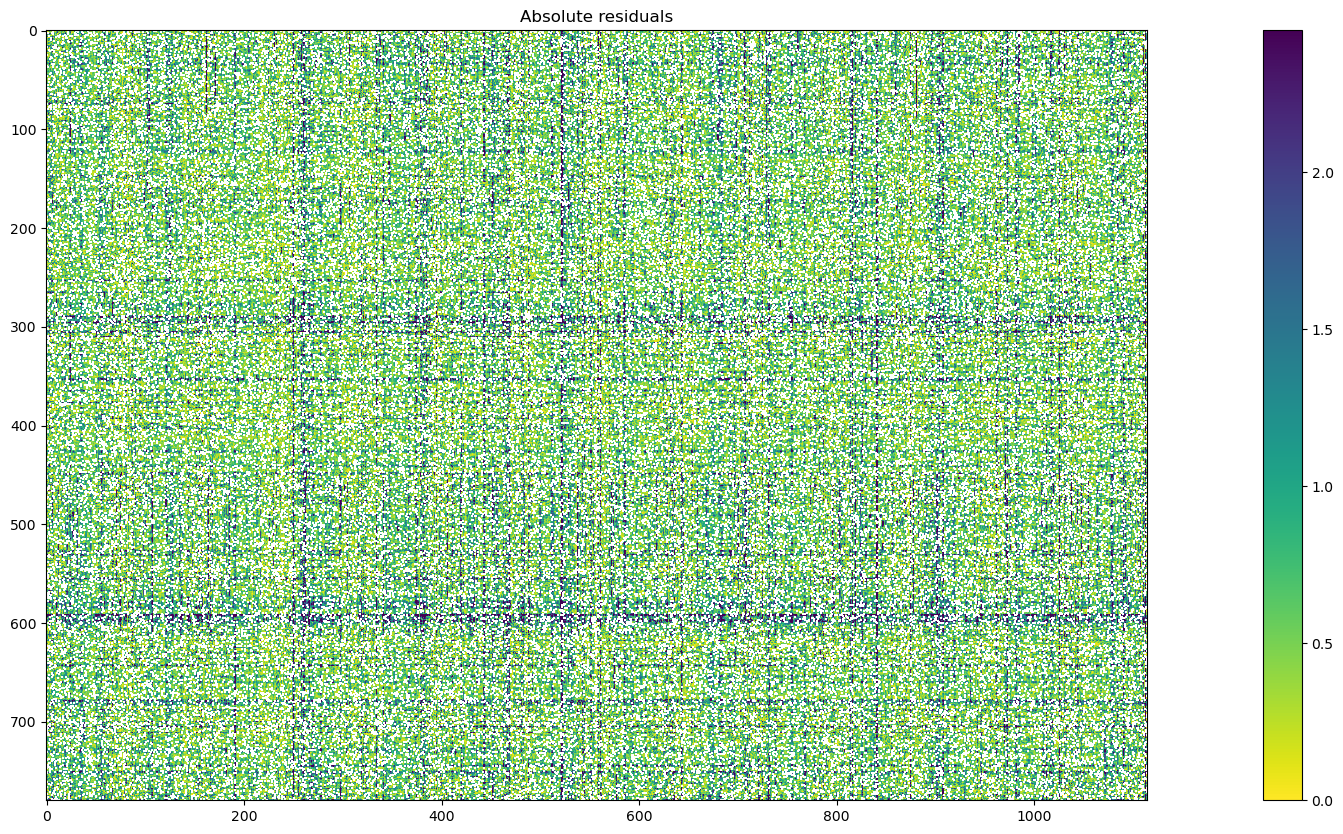

In [11]:
error_heatmap(M, Mhat, mask_test, figsize=(30,10))